In [ ]:
!git clone https://github.com/sophiachann/ObjectDetectionProject-IKEAFurnituresRecommender.git

Cloning into 'ObjectDetectionProject-IKEAFurnituresRecommender'...
remote: Enumerating objects: 1612, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 1612 (delta 76), reused 66 (delta 20), pack-reused 1459
Receiving objects: 100% (1612/1612), 82.55 MiB | 17.57 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Updating files: 100% (1441/1441), done.


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Load the pre-trained VGG model
vgg_model = models.vgg16(pretrained=True)
vgg_model.classifier = vgg_model.classifier[:-6]
# modules = list(vgg_model.children())[:-1]
# vgg_model = nn.Sequential(*modules)
vgg_model.eval()  # Set the model to evaluation mode
if torch.cuda.is_available():
    # Move the model to the GPU
    vgg_model = vgg_model.to('cuda')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 141MB/s] 


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os


class CustomDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.transform = transforms.Compose([
              transforms.Resize((224, 224)),
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])])
        # Unnormalize the image
        self.inverse_tranform = transforms.Compose([
              transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                   std=[1/0.229, 1/0.224, 1/0.225])])
        self.classes = self.get_folder_names()

        # Get the list of file paths in the data directory
        self.get_file_paths()
        self.file_paths = list(self.img_to_class.keys())

    def __len__(self):
        return len(self.file_paths)

    def __class_len__(self, c):
        return self.classes[c]

    def __getitem__(self, idx):
        # Load the image and label based on the index
        image_path = self.file_paths[idx]
        image = Image.open(image_path)
        label = self.img_to_class[image_path]

        # Apply transformations, if specified
        if self.transform:
            image = self.transform(image)

        return image, label, idx

    def get_folder_names(self,):
        folder_names = {}
        for item in os.listdir(self.data_dir):
            item_path = os.path.join(self.data_dir, item)
            if os.path.isdir(item_path):
                file_list = os.listdir(item_path)
                folder_names[item] = len([
                    f for f in file_list if os.path.isfile(
                        os.path.join(item_path, f))])
        return folder_names

    def get_file_paths(self):
        self.img_to_class = {}
        for i, c in enumerate(self.classes.keys()):
            file_paths = glob.glob(self.data_dir + '/' + c + '/*.jpg')
            for p in file_paths:
                self.img_to_class[p] = i

    def visualize(self, image_tensor):
        # Convert the tensor to a numpy array
        image_tensor = self.inverse_tranform(image_tensor)
        image_array = image_tensor.numpy()

        # Transpose the array to match the channel-last format expected by matplotlib
        image_array = image_array.transpose(1, 2, 0)

        # Display the image using matplotlib
        plt.imshow(image_array)
        plt.axis('off')
        plt.show()

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Specify the path to your data directory
data_dir = "/content/ikea-data"

# Create an instance of the CustomDataset
custom_dataset = CustomDataset(data_dir)

train_ratio = 0.8
val_ratio = 1 - train_ratio

# Calculate the number of samples for each split
num_samples = len(custom_dataset)
train_size = int(train_ratio * num_samples)
val_size = num_samples - train_size

# Use random_split to split the dataset
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

# Create a DataLoader to handle batching and shuffling of the data
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [ ]:
from collections import defaultdict
from tqdm import tqdm

def create_database(model, dataloader):
    database = defaultdict(list)
    for images, labels, idxs in tqdm(dataloader,
                                     desc='Processing items', unit='item'):
        # Move the images and labels to the GPU if available
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        # Perform forward pass
        with torch.no_grad():
            outputs = model(images)

        for i, (emb, label) in enumerate(zip(outputs, labels)):
            database[label.cpu().item()].append((emb, idxs[i]))

    return database

In [ ]:
database = create_database(vgg_model, train_dataloader)

Processing items: 100%|██████████| 35/35 [00:15<00:00,  2.30item/s]


In [ ]:
import torch.nn.functional as F

def get_most_similar(model, img_tensor, sub_database):
    similarity = float('-inf')
    if torch.cuda.is_available():
        img_tensor = img_tensor.cuda()
    img_tensor = model(img_tensor)

    for emb, idx in sub_database:
        sim = F.cosine_similarity(img_tensor, emb.unsqueeze(0)).item()
        if sim > similarity:
            similarity = sim
            similar_item = idx.item()
    return similar_item, sim

In [ ]:
results = []
for query_tensor, query_label, idx in val_dataloader:
    similar_idx, val = get_most_similar(vgg_model, query_tensor, database[query_label.item()])
    results.append([query_tensor, similar_idx, val])

In [ ]:
i = 13
query_tensor, similar_idx, val = results[i]

In [ ]:
val

0.8496232628822327

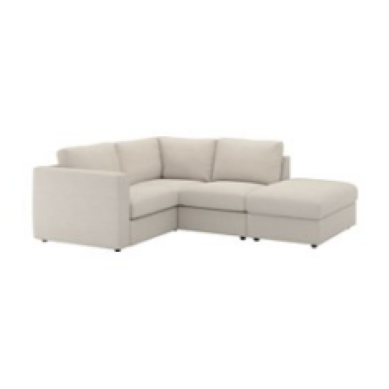

In [ ]:
custom_dataset.visualize(query_tensor[0])

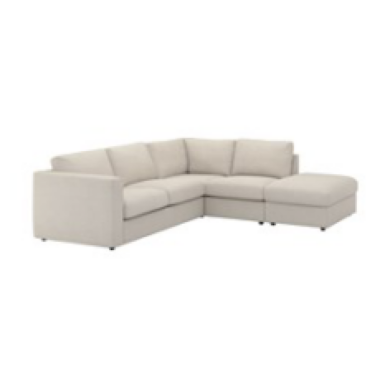

In [ ]:
custom_dataset.visualize(val_dataset.dataset.__getitem__(similar_idx)[0])

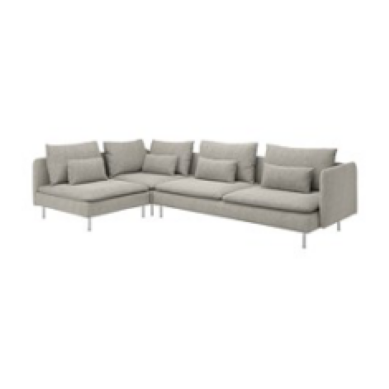

In [ ]:
custom_dataset.visualize(query_tensor[0])

In [ ]:
val

0.6220018863677979

In [ ]:
!pip install hnswlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.7.0-cp310-cp310-linux_x86_64.whl size=2119685 sha256=930e1a41f5ca0df3fa19abf024e061c2b9da3d249a17955a6fbe5fa53505647b
  Stored in directory: /root/.cache/pip/wheels/8a/ae/ec/235a682e0041fbaeee389843670581ec6c66872db856dfa9a4
Successfully built hnswlib


In [ ]:
query_tensor.numpy()[0].shape

(1, 3, 224, 224)

In [ ]:
import hnswlib
import numpy as np


def create_database(model, dataloader):
    num_items = len(dataloader.dataset)
    dim = 4096
    to_add = np.zeros((num_items, dim))
    ids = np.arange(num_items)
    # Declaring index
    p = hnswlib.Index(space = 'cosine', dim = dim) # possible options are l2, cosine or ip
    # Initializing index - the maximum number of elements should be known beforehand
    p.init_index(max_elements = num_items, ef_construction = 100, M = 16)
    mapper = {}
    curr = 0
    for images, labels, idxs in tqdm(dataloader,
                                     desc='Processing items', unit='item'):
        # Move the images and labels to the GPU if available
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        # Perform forward pass
        with torch.no_grad():
            outputs = model(images)
        to_add[curr: curr + len(outputs)] = outputs.cpu().numpy()
        k = 0
        for i in range(curr, curr + len(outputs)):
            mapper[i] = idxs[k]
            k += 0
        curr += len(outputs)

    # Element insertion (can be called several times):
    p.add_items(to_add, ids)
    # Controlling the recall by setting ef:
    p.set_ef(50) # ef should always be > k
    return p, mapper

In [ ]:
p, mapper = create_database(vgg_model, train_dataloader)

Processing items: 100%|██████████| 35/35 [00:08<00:00,  3.96item/s]


In [ ]:
query, _, _ = next(iter(val_dataloader))
query = query.cuda()

In [ ]:
# Query dataset, k - number of the closest elements (returns 2 numpy arrays)
labels, distances = p.knn_query(vgg_model(query).detach().cpu().numpy(), k = 3)

In [ ]:
distances

array([[0.02661318, 0.0298422 , 0.05769932]], dtype=float32)

In [ ]:
labels

array([[ 511,  852, 1072]], dtype=uint64)

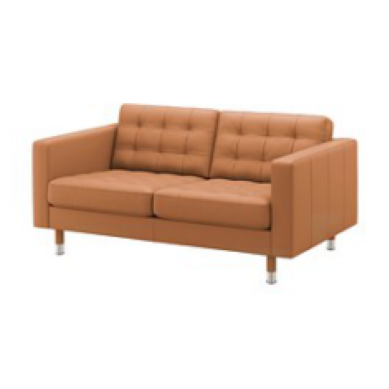

In [ ]:
custom_dataset.visualize(val_dataset.dataset.__getitem__(labels[0][1])[0])

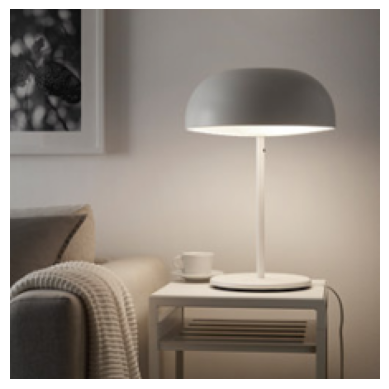

In [ ]:
custom_dataset.visualize(query_tensor[0])